In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, PReLU, Input, Reshape
from tensorflow.keras.models import Model

def build_encoder(input_shape):
    input_layer = Input(shape=input_shape)

    # Convolutional Layers
    x = Conv1D(filters=128, kernel_size=5, padding='valid')(input_layer)
    x = PReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=256, kernel_size=11, padding='valid')(x)
    x = PReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=512, kernel_size=21, padding='valid')(x)
    x = PReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)

    # Flatten the output from Conv layers
    x = Flatten()(x)

    # Fully Connected Layers
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(128)(x)
    x = PReLU()(x)
    x = Dense(64)(x)
    x = PReLU()(x)

    # Latent Space
    latent_space = Dense(10, name='latent_space')(x)

    return Model(input_layer, latent_space, name='encoder')

def build_decoder(latent_dim, output_dim):
    latent_input = Input(shape=(latent_dim,))

    # Fully Connected Layers
    x = Dense(64)(latent_input)
    x = PReLU()(x)
    x = Dense(256)(x)
    x = PReLU()(x)
    x = Dense(1024)(x)
    x = PReLU()(x)
    x = Dense(output_dim)(x)
    x = Reshape((output_dim, 1))(x)

    return Model(latent_input, x, name='decoder')

def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(latent_dim=10, output_dim=input_shape[0])

    input_layer = Input(shape=input_shape)
    latent_space = encoder(input_layer)
    reconstructed_output = decoder(latent_space)

    return Model(input_layer, reconstructed_output, name='autoencoder')

In [11]:
# Define input shape (e.g., 3892 spectral elements)
input_shape = (1000, 1)  # Modify according to your input shape

autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 1000, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 10)             │    18,204,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1000, 1)        │     1,306,856 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,511,026 (74.43 MB)

 Trainable params: 19,511,026 (74.43 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import smplotlib 
import pandas as pd 

data_df = pd.read_csv('/Users/tkiker/Documents/GitHub/AGN-UMAP/code/monthly/july2024/wk4/sdss/code/normalized_spectra.csv')

input_spectra = data_df.to_numpy().T

# Split the data into training and validation sets
X_train, X_val = train_test_split(input_spectra, test_size=0.2, random_state=42)
spectra_IDs_train, spectra_IDs_val = train_test_split(list(data_df), test_size=0.2, random_state=42)

Epoch 1/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - loss: 0.0217 - val_loss: 0.0242
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 203ms/step - loss: 0.0241 - val_loss: 0.0234
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 202ms/step - loss: 0.0227 - val_loss: 0.0231
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - loss: 0.0234 - val_loss: 0.0231
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 230ms/step - loss: 0.0238 - val_loss: 0.0227
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0245 - val_loss: 0.0226
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 260ms/step - loss: 0.0216 - val_loss: 0.0227
Epoch 9/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 21s 257ms/step - loss: 0.0233 - val_loss: 0.0213
Epoch 10/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - loss: 0.0217 - val_loss: 0.0218


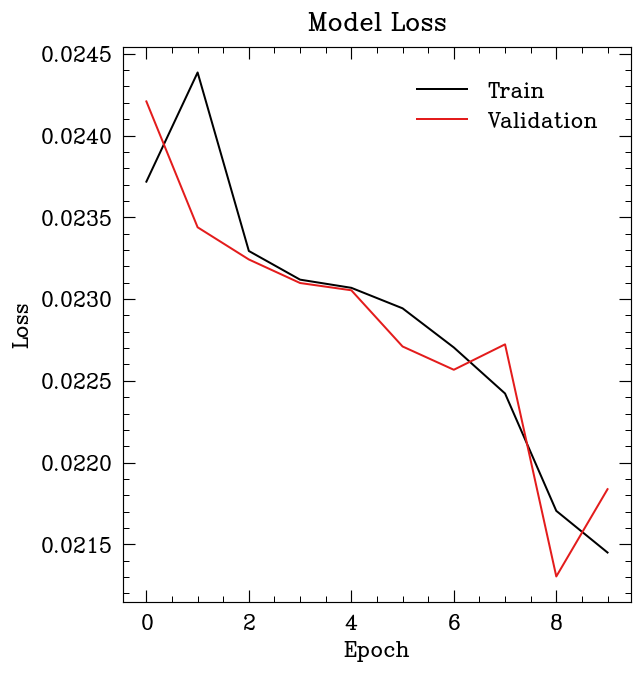

In [21]:
# Train the autoencoder
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_val, X_val))

# Save the training history
history_dict = history.history

# Plot the training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plots
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(1000,) (1000,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(1000,) (1000,)


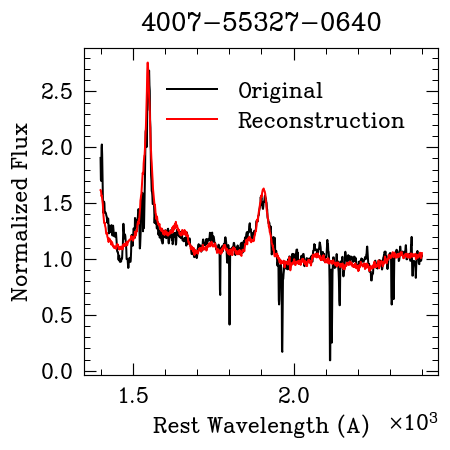

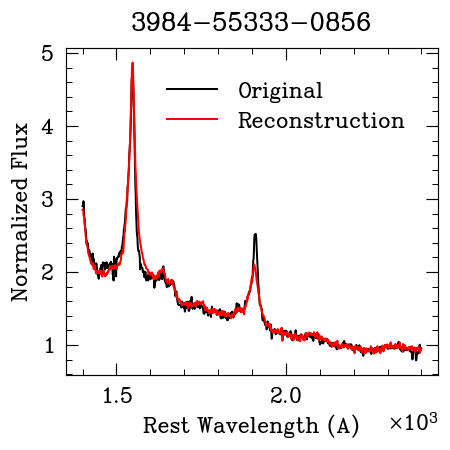

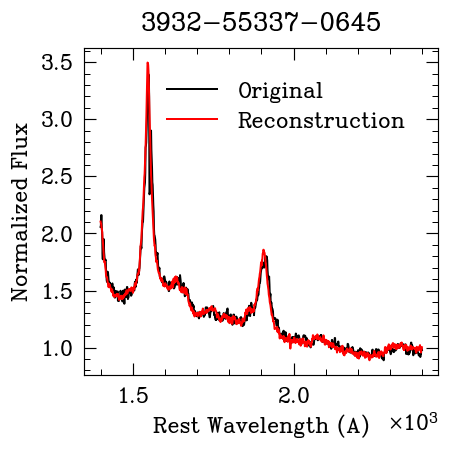

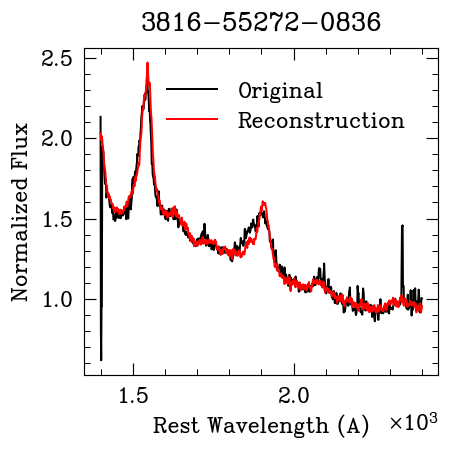

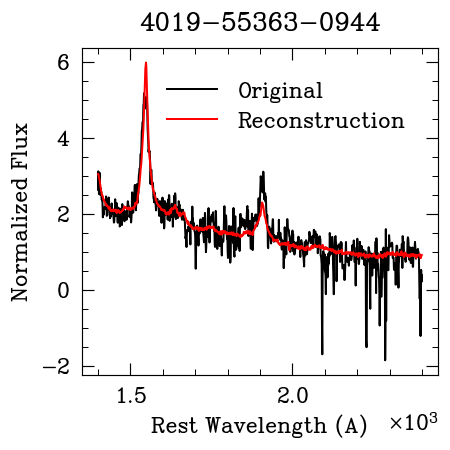

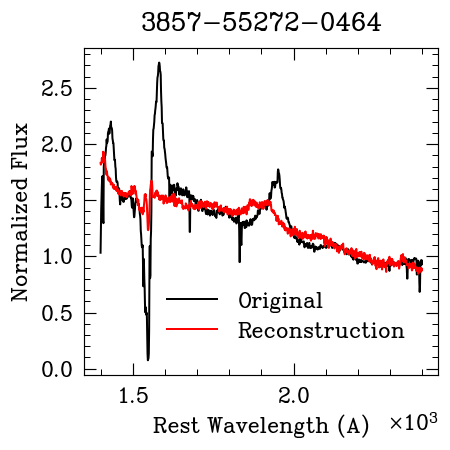

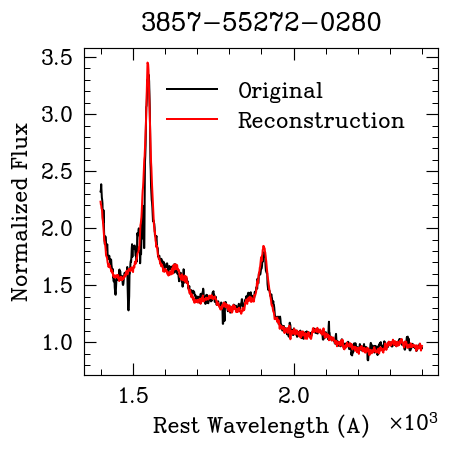

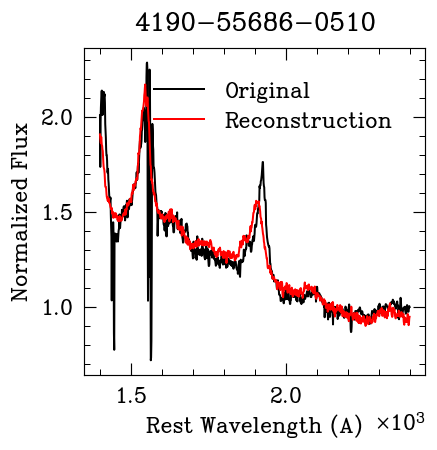

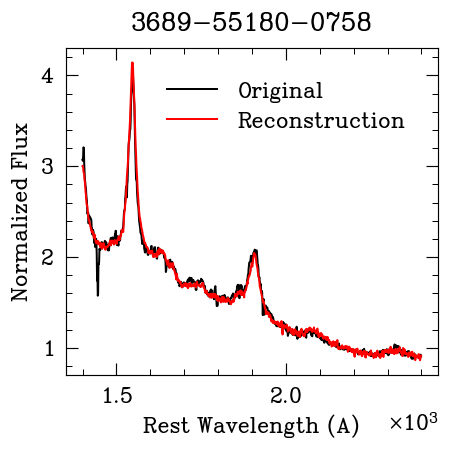

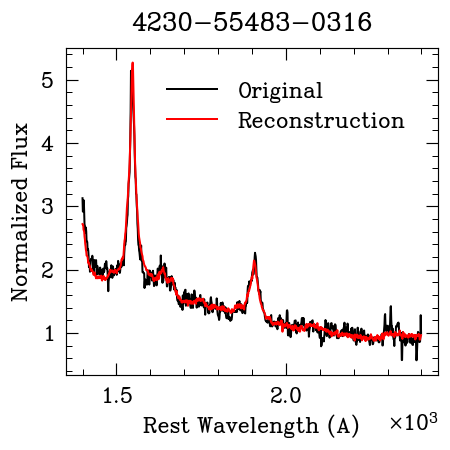

In [38]:
import numpy as np

x = np.arange(1400, 2400, 1)

for index in range(10): 
    y = np.expand_dims(X_val[index], axis=0)

    # Predict the reconstruction
    predicted = autoencoder.predict(y)

    # Reshape the prediction to remove the batch dimension
    y = y.flatten()
    predicted = np.squeeze(predicted, axis=0).flatten()

    print(y.shape, predicted.shape)

    fig, ax = plt.subplots(figsize=(4,4))
    ax.plot(x, y, color='black', label='Original')
    ax.plot(x, predicted, color='red', label='Reconstruction')

    ax.legend()
    ax.set(title=spectra_IDs_val[index], xlabel='Rest Wavelength (A)', ylabel='Normalized Flux')

    fig.tight_layout()


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step


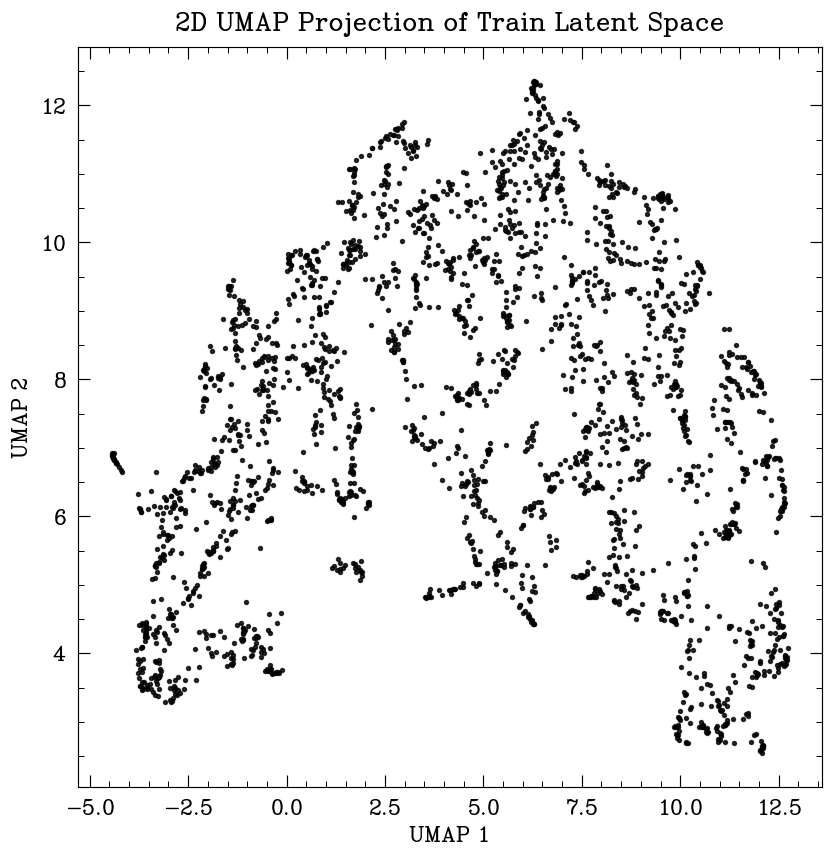

In [42]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Get the encoder part of the autoencoder
encoder = autoencoder.get_layer('encoder')

# Use the encoder to predict the latent space representations for X_val
latent_space_representations = encoder.predict(X_train)

# Use UMAP to reduce the dimensionality to 2D
umap_2d = umap.UMAP(n_components=2, random_state=42)
latent_space_2d = umap_2d.fit_transform(latent_space_representations)

# Plot the 2D latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], s=5, cmap='Spectral', alpha=0.8)
plt.title('2D UMAP Projection of Train Latent Space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


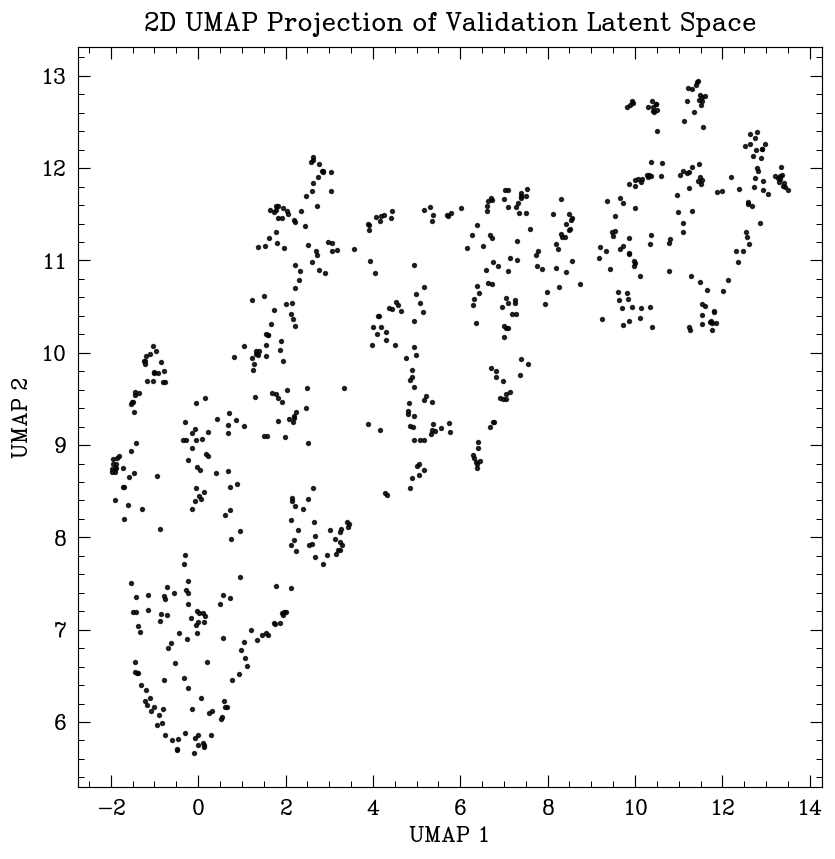

In [43]:
import umap
import matplotlib.pyplot as plt
import pandas as pd

# Get the encoder part of the autoencoder
encoder = autoencoder.get_layer('encoder')

# Use the encoder to predict the latent space representations for X_val
latent_space_representations = encoder.predict(X_val)

# Use UMAP to reduce the dimensionality to 2D
umap_2d = umap.UMAP(n_components=2, random_state=42)
latent_space_2d = umap_2d.fit_transform(latent_space_representations)

# Plot the 2D latent space
plt.figure(figsize=(8, 8))
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1], s=5, cmap='Spectral', alpha=0.8)
plt.title('2D UMAP Projection of Validation Latent Space')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [44]:
print(len(X_train), len(X_val))

2547 637
